<a href="https://colab.research.google.com/github/KarelZe/adv-ml/blob/main/AML_Bonus_MarkusBilz_2327197_VerenaHollinger_2055134.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [244]:
!pip install imbalanced-learn

In [245]:
#import dependencies
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from google.colab import drive


import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.1)
sns.color_palette("rocket", as_cmap=True)
sns.set_palette("rocket")

import matplotlib.pyplot as plt
%matplotlib inline

# increase the number of rows displayed to fully display all (transposed) features.
pd.options.display.max_rows = 1000


# Task 1: Explain dataset and business problems in two paragraphs. (10 points)

Peer-2-Peer Lending is a decentralized approach in which investors (most oftenly private investors) lend to debtors (typically private individuals). Peer-2-peer lending platforms such as Lending Club serve as an intermediary between investors and borrowers. Due to the decentralized structure, no banks are involved. The risk for a loan is that the borrower defaults partly or entirely. Expected interest and redemption payments may then not be made. The borrowers suffer a loss. Typically, investors invest in several loans to diversify their default risk. Ergo, one loan is financed by several investors. Of key Of central interest is whether a default of a loan can be predicted and with which features. The platform could use this information to reject loans that are highly likely to default during the application process, thus avoiding defaults.

The dataset contains loan data on loans, that where distributed through the peer-2-peer lending platform Lending club. The data includes information on payment history, loan terms, borrower information and most importantly the loan status. In overview, data can be classified into hard and soft features. Some features are categorical e. g. term, while others are numerical e. g. debt-to-income-ratio or unstructured e. g. purpose.



## Loading the data

Loan data is available from kaggle. Income data was downloaded from the [US Census Bureau](https://data.census.gov/cedsci/table?q=S1901%3A%20INCOME%20IN%20THE%20PAST%2012%20MONTHS%20%28IN%202018%20INFLATION-ADJUSTED%20DOLLARS%29&g=0400000US01,02,04,05,06,08,09,10,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,44,45,46,47,48,49,50,51,53,54,55,56,72&tid=ACSST1Y2018.S1901&hidePreview=false). 

For Iso-Codes of state see [ISO](https://www.iso.org/obp/ui/#iso:code:3166:US).

In [246]:

drive.mount("/content/drive")

data = pd.read_csv('/content/drive/My Drive/AdvancedML/accepted_2007_to_2018Q4.csv')
income_by_states = pd.read_csv('/content/drive/My Drive/AdvancedML/ACSST1Y2018_S1901_data_with_overlays_2021-06-12T020307.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Task 2: Do an explanatory analysis for this dataset. (10 points)

In [247]:
print(data.shape)

(2260701, 151)


In [248]:
data.head().T

,0,1,2,3,4
id,68407277,68355089,68341763,66310712,68476807
member_id,NaN,NaN,NaN,NaN,NaN
loan_amnt,3600,24700,20000,35000,10400
funded_amnt,3600,24700,20000,35000,10400
funded_amnt_inv,3600,24700,20000,35000,10400
term,36 months,36 months,60 months,60 months,60 months
int_rate,13.99,11.99,10.78,14.85,22.45
installment,123.03,820.28,432.66,829.9,289.91
grade,C,C,B,C,F
sub_grade,C4,C1,B4,C5,F1


In [249]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,2.2607e+06,2.2607e+06,8.38861e+07,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
member_id,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,2.26067e+06,NaN,NaN,NaN,15046.9,9190.25,500,8000,12900,20000,40000
funded_amnt,2.26067e+06,NaN,NaN,NaN,15041.7,9188.41,500,8000,12875,20000,40000
funded_amnt_inv,2.26067e+06,NaN,NaN,NaN,15023.4,9192.33,0,8000,12800,20000,40000
term,2260668,2,36 months,1609754,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,2.26067e+06,NaN,NaN,NaN,13.0928,4.83214,5.31,9.49,12.62,15.99,30.99
installment,2.26067e+06,NaN,NaN,NaN,445.807,267.174,4.93,251.65,377.99,593.32,1719.83
grade,2260668,7,B,663557,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub_grade,2260668,35,C1,145903,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [250]:
data.isna().sum()

id                                                  0
member_id                                     2260701
loan_amnt                                          33
funded_amnt                                        33
funded_amnt_inv                                    33
term                                               33
int_rate                                           33
installment                                        33
grade                                              33
sub_grade                                          33
emp_title                                      167002
emp_length                                     146940
home_ownership                                     33
annual_inc                                         37
verification_status                                33
issue_d                                            33
loan_status                                        33
pymnt_plan                                         33
url                         

Not all features are known at the time, when the loan is handed out. Therefore, a preselection is done to those features that can be known during the application process by using a [dictionary.](https://drive.google.com/file/d/1UzyKMtrzL3aEEQpeYIz_qjBWyW-lAMr0/view) 

Moreover, the columns `url` or `desc`, as the info is no longer available on the lending club website.

In [251]:
a_priori_known = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',  'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',  'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'revol_bal_joint']

data = data[a_priori_known]

In [252]:
threshold = 0.80

percentage_missing_val = data.isna().sum()/len(data)
percentage_missing_val = percentage_missing_val[percentage_missing_val >= threshold]

print(percentage_missing_val)
threshold_abs = int(threshold * len(data))

data = data.dropna(axis=1, thresh=threshold_abs)

print(data.shape)

mths_since_last_record       0.841131
annual_inc_joint             0.946605
dti_joint                    0.946607
verification_status_joint    0.948808
revol_bal_joint              0.952218
dtype: float64
(2260701, 74)



Some rows are present, where the volume and many other features are null. We exclude these loans without volume from analysis.



In [253]:
data = data[data.loan_amnt.notna()]

In [254]:
# TODO: Passt für mich addr_state kategorisch zu machen.

# convert to categorical
categorical = ['addr_state', 'term', 'application_type', 'initial_list_status', 'loan_status', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose','emp_length']
data[categorical] = data[categorical].apply(lambda x: x.astype('category'))

# convert to string
strs = ['emp_title', 'title', 'zip_code']
data[strs] = data[strs].apply(lambda x: x.astype('string'))

# convert to datetime
dts = ['earliest_cr_line', 'issue_d', 'last_credit_pull_d']
data[dts] = data[dts].apply(lambda x: pd.to_datetime(x, format="%b-%Y",  errors='coerce'))

# convert to integer
#ints = ['id']
#data[ints] = data[ints].apply(lambda x: x.astype('int'))

print(data.dtypes)

loan_amnt                            float64
funded_amnt                          float64
funded_amnt_inv                      float64
term                                category
int_rate                             float64
installment                          float64
grade                               category
sub_grade                           category
emp_title                             string
emp_length                          category
home_ownership                      category
annual_inc                           float64
verification_status                 category
issue_d                       datetime64[ns]
loan_status                         category
purpose                             category
title                                 string
zip_code                              string
addr_state                          category
dti                                  float64
delinq_2yrs                          float64
earliest_cr_line              datetime64[ns]
fico_range

##Number of unique classes per feature

In [255]:
data_classes = []
for row in data.columns.tolist():
    data_classes.append({'column': row, 'count': len(data[row].unique())})
amount = pd.DataFrame(data_classes).sort_values('count')
print(amount)

                        column   count
35                 policy_code       1
36            application_type       2
30         initial_list_status       2
3                         term       2
12         verification_status       3
63                num_tl_30dpd       6
10              home_ownership       6
6                        grade       7
62            num_tl_120dpd_2m       8
14                 loan_status       9
37              acc_now_delinq      10
9                   emp_length      12
45    chargeoff_within_12_mths      12
68        pub_rec_bankruptcies      13
15                     purpose      14
34  collections_12_mths_ex_med      17
24              inq_last_6mths      29
65          num_tl_op_past_12m      34
64          num_tl_90g_dpd_24m      35
7                    sub_grade      35
20                 delinq_2yrs      38
69                   tax_liens      43
53              num_actv_bc_tl      43
26                     pub_rec      44
52       num_accts_ever_1

The features "purpose" and "title" contain similar content. Since "purpose" only contains 14 classes and "title" contains more than 60,000 classes we keep "purpose" and drop "title"

In [256]:
data = data.drop(columns=['title'])

Next, we analyze categorical features by looking at their $k$ most frequent values.

In [257]:
k = 10

data['term'].value_counts().head(k)

 36 months    1609754
 60 months     650914
Name: term, dtype: int64

In [258]:
data['addr_state'].value_counts().head(k)

CA    314533
NY    186389
TX    186335
FL    161991
IL     91173
NJ     83132
PA     76939
OH     75132
GA     74196
VA     62954
Name: addr_state, dtype: int64

In [259]:
data['application_type'].value_counts().head(k)

Individual    2139958
Joint App      120710
Name: application_type, dtype: int64

In [260]:
data['initial_list_status'].value_counts().head(k)

w    1535467
f     725201
Name: initial_list_status, dtype: int64

In [261]:
data['loan_status'].value_counts().head(k)

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

In [262]:
data['grade'].value_counts().head(k)

B    663557
C    650053
A    433027
D    324424
E    135639
F     41800
G     12168
Name: grade, dtype: int64

In [263]:
data['sub_grade'].value_counts().head(k)

C1    145903
B5    140288
B4    139793
B3    131514
C2    131116
C3    129193
C4    127115
B2    126621
B1    125341
C5    116726
Name: sub_grade, dtype: int64

In [264]:
data['home_ownership'].value_counts().head(k)

MORTGAGE    1111450
RENT         894929
OWN          253057
ANY             996
OTHER           182
NONE             54
Name: home_ownership, dtype: int64

In [265]:
data['verification_status'].value_counts().head(k)

Source Verified    886231
Not Verified       744806
Verified           629631
Name: verification_status, dtype: int64

In [266]:
data['purpose'].value_counts().head(k)

debt_consolidation    1277877
credit_card            516971
home_improvement       150457
other                  139440
major_purchase          50445
medical                 27488
small_business          24689
car                     24013
vacation                15525
moving                  15403
Name: purpose, dtype: int64

In [267]:
data['emp_length'].value_counts().head(k)

10+ years    748005
2 years      203677
< 1 year     189988
3 years      180753
1 year       148403
5 years      139698
4 years      136605
6 years      102628
7 years       92695
8 years       91914
Name: emp_length, dtype: int64

##Analyze loan status

In [268]:
data['loan_status'].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

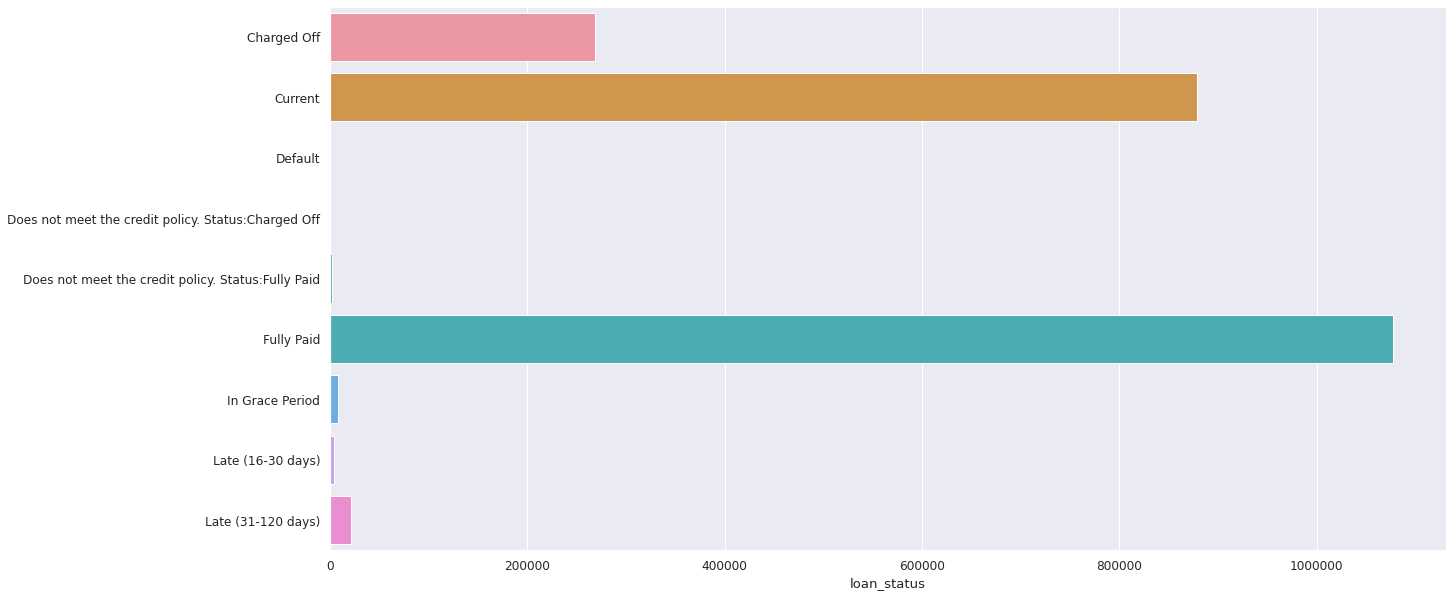

In [269]:
loan_status_absolute = data['loan_status'].value_counts()
loan_status_absolute = loan_status_absolute.to_frame()

fig, ax = plt.subplots(figsize=(20,10))
plt.ticklabel_format(style='plain')
sns.barplot(x='loan_status', y=loan_status_absolute.index,  data=loan_status_absolute, ax=ax);

In [270]:
default_categories = ['Default', 'Charged Off', 'Does not meet the credit policy. Status:Charged Off']
data['TARGET'] = data['loan_status'].isin(default_categories)

data['TARGET'].value_counts()

False    1991308
True      269360
Name: TARGET, dtype: int64

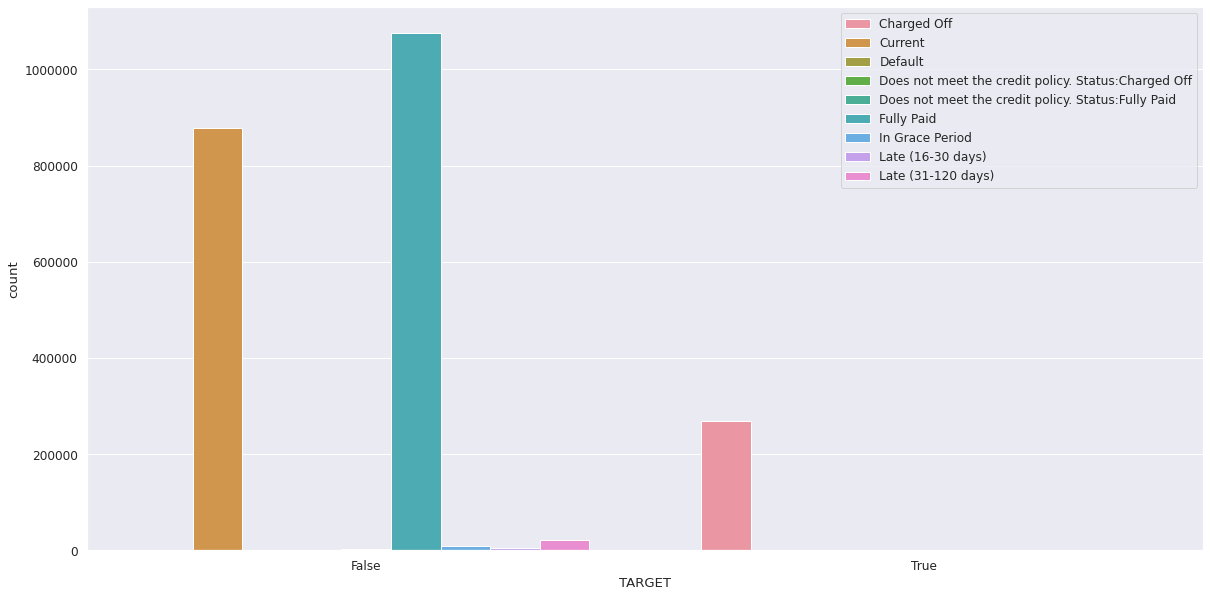

In [271]:
fig, ax = plt.subplots(figsize=(20,10))
plt.ticklabel_format(style='plain')
g = sns.countplot(x='TARGET', hue='loan_status', data=data);
g.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1);
plt.show();

## default status by debt-to-income-ratio
- For calculation of debt-to-income-ratio see [here.](https://www.lendingclub.com/loans/resource-center/calculating-debt-to-income)

**expectation**
- One would expect more defaults with a higher debt-to-income ratio, but no clear trend can be derived from data.

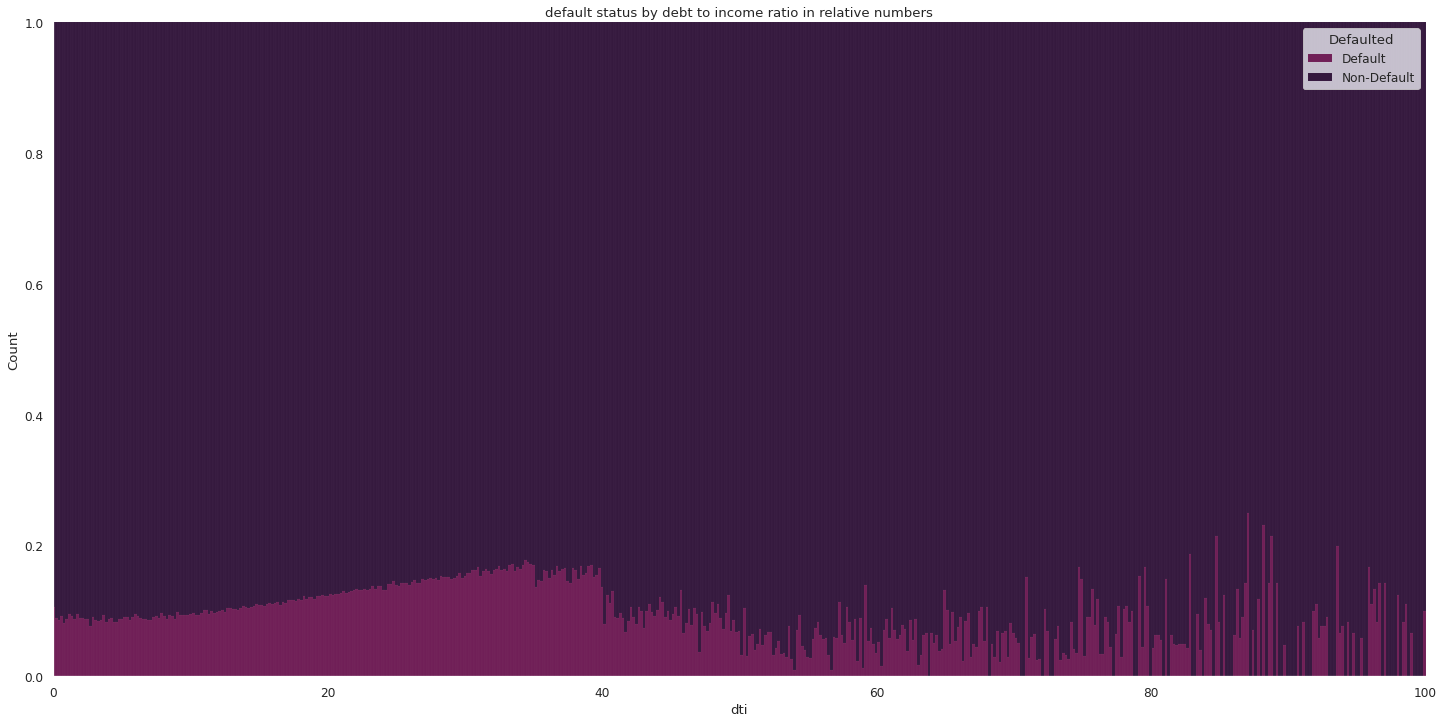

In [272]:
g = sns.displot(data, x='dti', hue='TARGET', multiple='fill', legend=False, height=10, aspect=20/10, alpha=1)
plt.title("default status by debt to income ratio in relative numbers")
plt.xlim(0, 100)
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Non-Default'])
plt.show(g);

## default status by term structure and amount

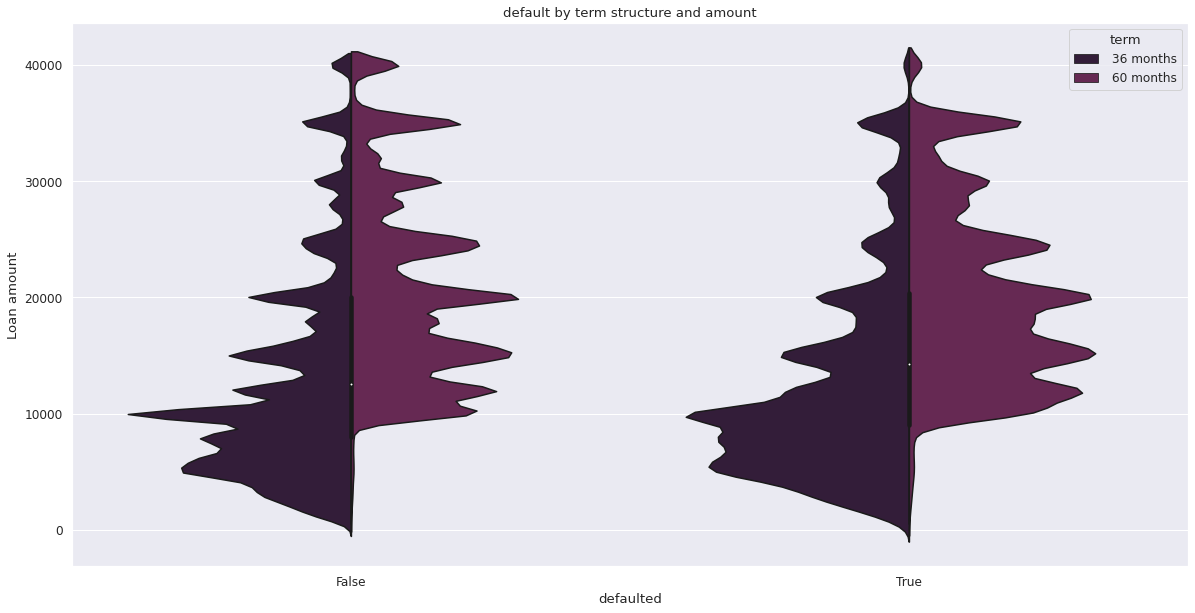

In [273]:
fig = plt.figure(figsize=(20,10))
sns.violinplot(x="TARGET",y="loan_amnt",data=data, hue="term", split=True)
plt.title("default by term structure and amount")
plt.xlabel("defaulted")
plt.ylabel("Loan amount");

## default status by grade

**expectation**
- Loans with a lower rating inherit a higher risk of default.

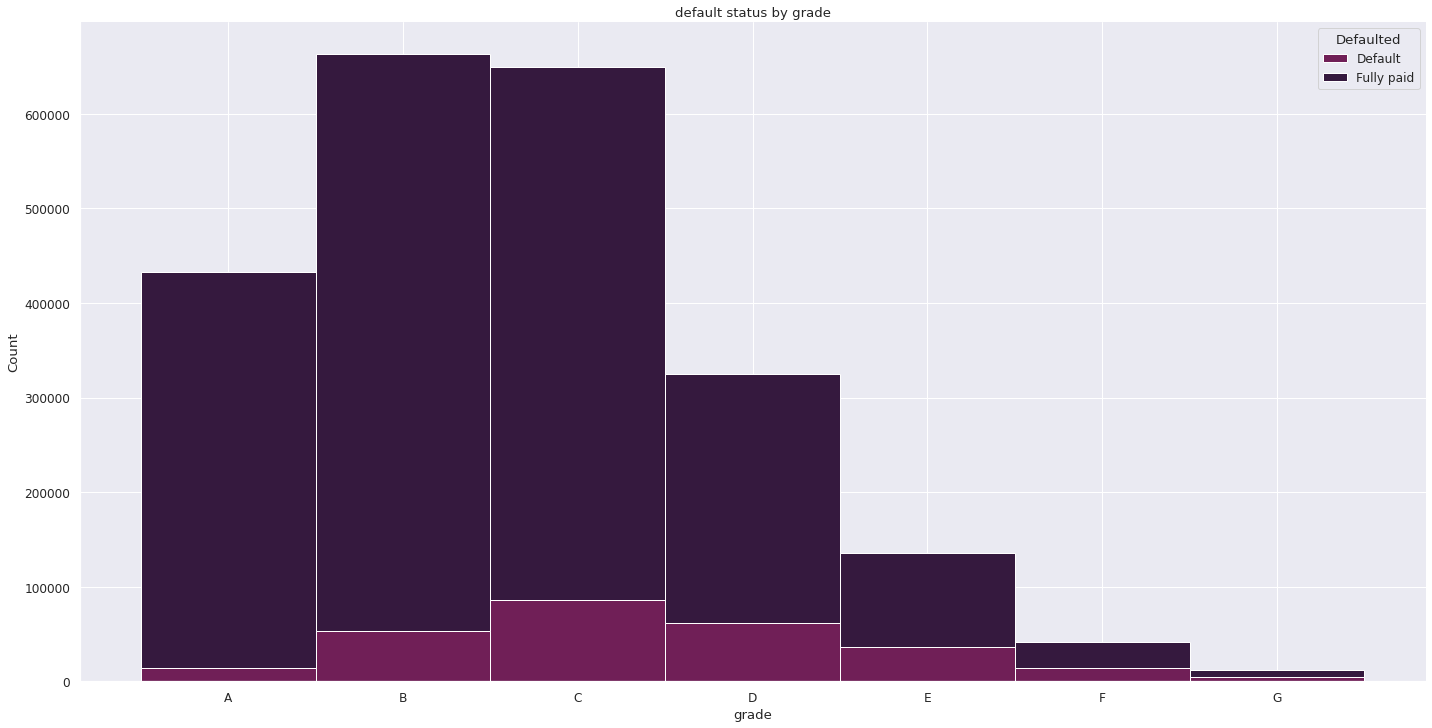

In [274]:
g = sns.displot(data, x='grade', hue='TARGET', multiple='stack', legend=False, height=10, aspect=20/10, alpha=1);
plt.title("default status by grade")
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Fully paid'])
plt.show(g);

## default status by grade and interest rate

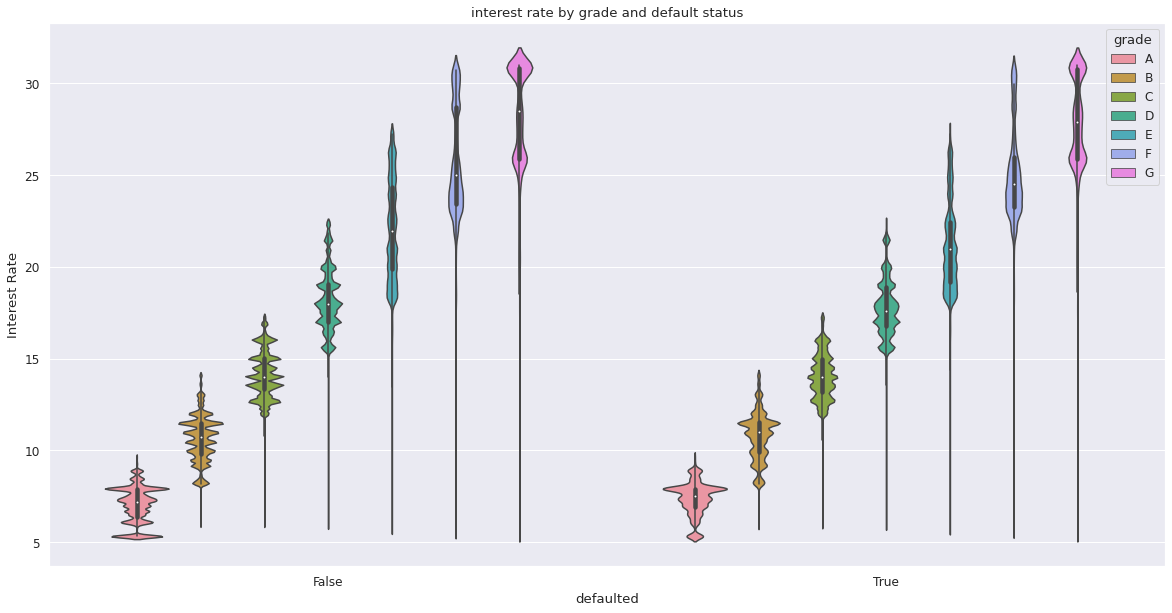

In [275]:
fig = plt.figure(figsize=(20,10))
sns.violinplot(x="TARGET",y="int_rate",data=data, hue="grade",)
plt.title("interest rate by grade and default status")
plt.xlabel("defaulted")
plt.ylabel("Interest Rate");

# Default status by application type

**expectation**
- Joint applications inherit lower risk of default.

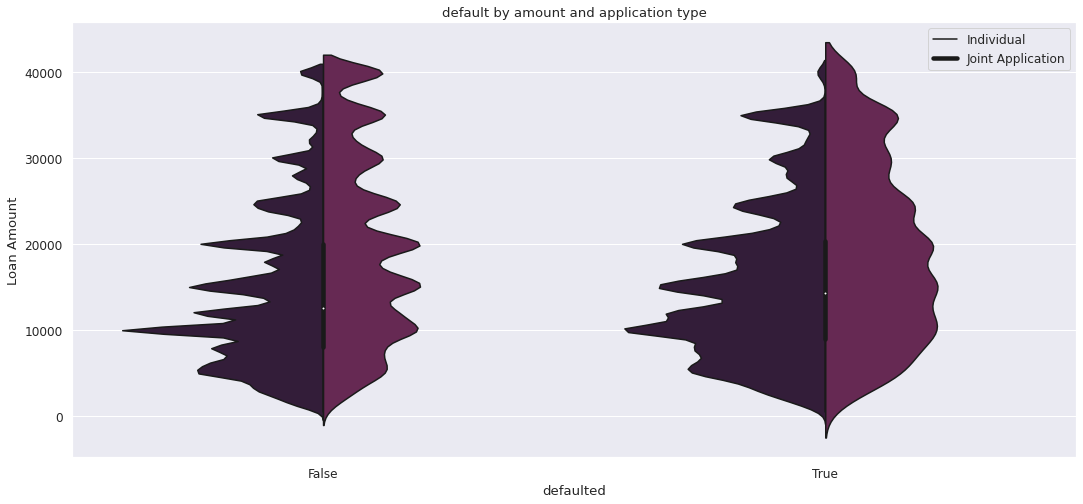

In [276]:
fig = plt.figure(figsize=(18,8))
sns.violinplot(x="TARGET",y="loan_amnt",data=data, hue="application_type", split=True)
plt.title("default by amount and application type")
plt.xlabel("defaulted")
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1, labels=['Individual', 'Joint Application']);
plt.ylabel("Loan Amount");

## Default status by working experience

**expectation**
- The longer the working experience, the smaller the probability of default.

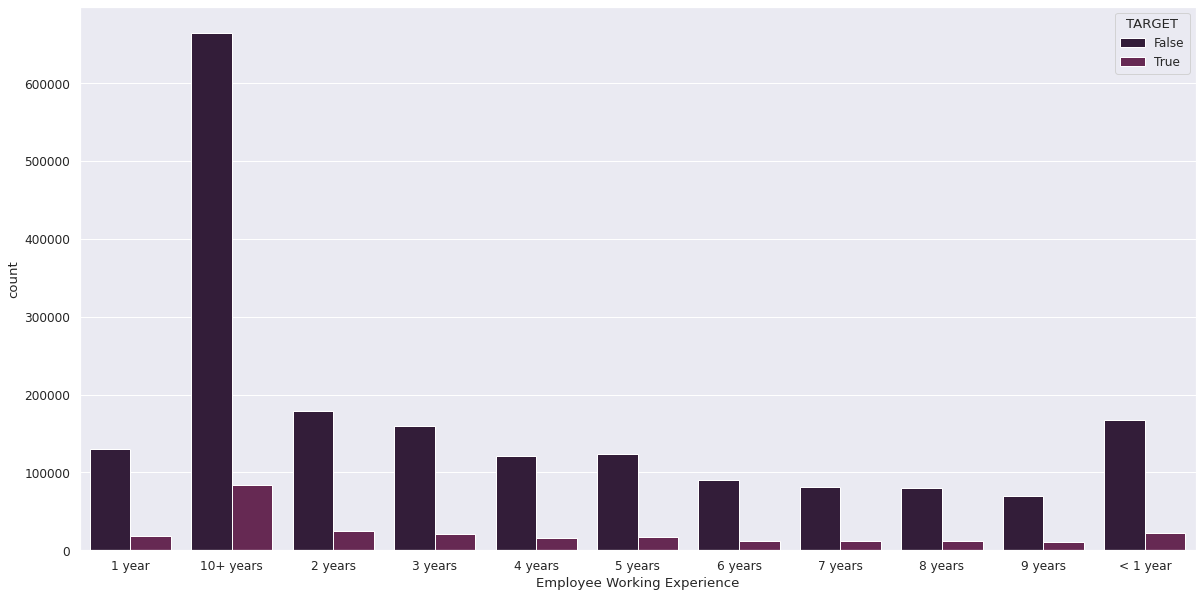

In [277]:
fig = plt.figure(figsize=(20,10))
sns.countplot(x='emp_length', hue='TARGET', data=data)
plt.xlabel('Employee Working Experience')
plt.show()

## Default status by state

**expectation**
- None.

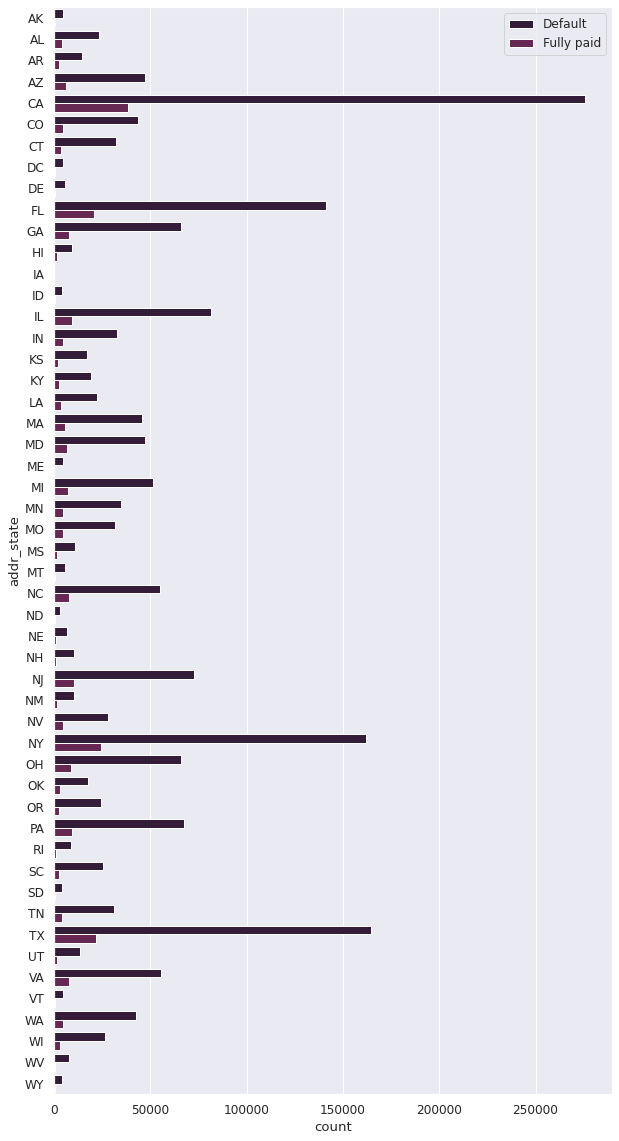

In [278]:
fig, ax = plt.subplots(figsize=(10,20))
plt.ticklabel_format(style='plain')
g = sns.countplot(y='addr_state', hue='TARGET', data=data, ax=ax);
g.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1, labels=['Default', 'Fully paid']);
plt.show();

## Interest rate by grade

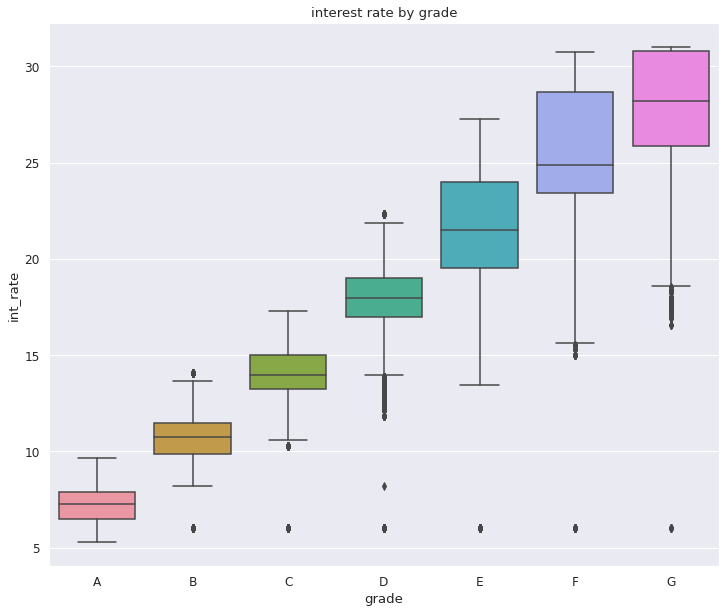

In [279]:
plt.figure(figsize=(12,10))
g = sns.boxplot(data=data, x='grade', y='int_rate')
plt.title("interest rate by grade")
plt.show(g);

## Analyze income


In [280]:
income_by_states = income_by_states[['NAME', 'S1901_C01_013E']]
income_by_states.rename(columns={'NAME':'state','S1901_C01_013E': 'income'}, inplace=True)

income_by_states.head(60)

,state,income
0,Geographic Area Name,Estimate!!Households!!Mean income (dollars)
1,Alabama,69091
2,Alaska,96080
3,Arizona,80477
4,Arkansas,66766
5,California,107384
6,Colorado,96218
7,Connecticut,111303
8,Delaware,84896
9,Florida,79968


In [281]:
state_map = pd.read_csv("/content/drive/My Drive/AdvancedML/states_mapping.csv", sep=';')
state_map.head(50)

,iso_code,subdivision_name
0,AL,Alabama
1,AK,Alaska
2,AS,American Samoa
3,AZ,Arizona
4,AR,Arkansas
5,CA,California
6,CO,Colorado
7,CT,Connecticut
8,DE,Delaware
9,DC,District of Columbia


In [282]:
# remove comments from df
income_by_states.drop(income_by_states.index[[0]], inplace=True)

# add iso codes and make subselection
income_by_states = income_by_states.merge(state_map,how='left',left_on='state', right_on='subdivision_name')
income_by_states = income_by_states[['iso_code', 'income']]

income_by_states.head(60)

,iso_code,income
0,AL,69091
1,AK,96080
2,AZ,80477
3,AR,66766
4,CA,107384
5,CO,96218
6,CT,111303
7,DE,84896
8,FL,79968
9,GA,82489


In [283]:
lut_income = dict(income_by_states.values)
data["addr_state_avg_income"] = data["addr_state"].replace(lut_income)
data.head().T

,0,1,2,3,4
loan_amnt,3600,24700,20000,35000,10400
funded_amnt,3600,24700,20000,35000,10400
funded_amnt_inv,3600,24700,20000,35000,10400
term,36 months,36 months,60 months,60 months,60 months
int_rate,13.99,11.99,10.78,14.85,22.45
installment,123.03,820.28,432.66,829.9,289.91
grade,C,C,B,C,F
sub_grade,C4,C1,B4,C5,F1
emp_title,leadman,Engineer,truck driver,Information Systems Officer,Contract Specialist
emp_length,10+ years,10+ years,10+ years,10+ years,3 years


<Figure size 1440x720 with 0 Axes>

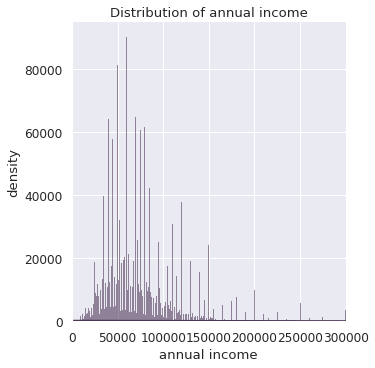

In [284]:
fig = plt.figure(figsize=(20,10))
sns.displot(data['annual_inc'], kde=True)
#sns.displot(data['addr_state_avg_income'],rug=True, kde=False)
plt.title("Distribution of annual income")
plt.xlim(0, 300000)
plt.xlabel("annual income")
plt.ylabel("density")
plt.show()

##Analyze effect of joint/ individual application

In [285]:
data['application_type'].value_counts()

Individual    2139958
Joint App      120710
Name: application_type, dtype: int64

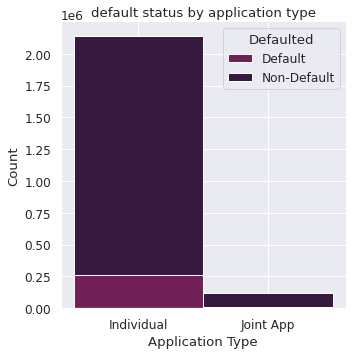

In [286]:
g = sns.displot(data, x='application_type', hue='TARGET', multiple='stack', legend=False, alpha=1)
plt.xlabel("Application Type")
plt.title("default status by application type")
plt.legend(title='Defaulted', loc='upper right', labels=['Default', 'Non-Default'])

plt.show(g);

In [287]:
#data_jointapp = data.loc[data['application_type'] == 'Joint App']
#data_indidualapp = data.loc[data['application_type'] == 'Individual']

In [288]:
# die Methode ist irgendwo rauskopiert, wenn wir sie drin lassen wollen muss ich sie noch ein bisschen was abändern
def null_values(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [289]:
#miss_values = null_values(data_jointapp)
#miss_values.head(20)

In [290]:
#miss_values = null_values(data_indidualapp)
#miss_values.head(20)

In [291]:
#miss_values = null_values(data)
#miss_values.head()


As the amount of missing values, that remain in the dataset, is relatively small, we fill missing values with the modus of each feature.

In [292]:
#data.fillna(data.mode().iloc[0], inplace = True)

## Data Preprocessing

Since the features have different units, Scaling and Standardization of the numeric features are necessary. And since a Support Vector Machine required data with values between 0 and 1 the Standardization is conducted first.

In [293]:
#data_num = data.select_dtypes(include=[np.float64, np.float32])
#data_num_columns = data_num.columns


# TODO: Remove the following code
#data = data.drop(columns=data_num_columns)

#standardizer = StandardScaler()
#data_standardized = pd.DataFrame(standardizer.fit_transform(data_num), columns = data_num_columns)
#data_standardized.describe()

In [294]:
#min_max = MinMaxScaler()
#data_scaled = pd.DataFrame(min_max.fit_transform(data[data_num_columns]), columns = data_num_columns)
#data_scaled.describe()

All categorical values ar binarized using get_dummies

In [295]:
#data_cat = data.select_dtypes(include=['category'])
#data_cat_columns = data_cat.columns
#data_cat_columns

In [296]:
#data = data.drop(columns=data_cat_columns)
#data_to_encode = data_cat.drop(columns=['loan_status'])
#data_encoded = pd.get_dummies(data_to_encode)
#data_encoded

If there are only two classes, they have a correlation of 1, so one class can be dropped without loosing any information

In [297]:
#data_encoded = data_encoded.drop(columns=['term_ 60 months', 'initial_list_status_w', 'application_type_Joint App'])
#data_encoded

In [298]:
#target = data[['TARGET']]
#data = data.drop(columns=['TARGET'])
#data = pd.concat([data, data_scaled, data_encoded], axis=1)
#data[['Target']] = target
#data

In [299]:
# TODO: Remove the following code
#data_to_encode = data[['term', 'verification_status','application_type']]
#enc = OneHotEncoder()
#df_num = enc.fit_transform(data_to_encode).toarray()
#df_num = pd.DataFrame(df_num)
#df_num

Split the data in test and training data

In [300]:
#X = data.iloc[:,:-1]
#y = data.iloc[:, -1]


In [301]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

The data is very imbalanced. Therefore further preprocessing is required

In [302]:
#sm = SMOTE(random_state=42)
#X_res, y_res = sm.fit_resample(X, y)

In [303]:
# from imblearn.over_sampling import RandomOverSampler 
# ros = RandomOverSampler(random_state=42)
# X_res, y_res = ros.fit_resample(X, y)

To identify similar features and relevant features (high correlation with target feature) a correlation analysis is conducted

In [304]:
#correlation with target feature
#corr = data.corr()['TARGET'].sort_values()
#print('Most Positive Correlations:\n',corr.tail(15))
#print('\nMost Negative Correlations:\n',corr.head(15))

## Task 3: Use LASSO for variable selection and explain results. (15 points)

## Task 4: Use logistic regression (in-sample) for default prediction. Interpret your results for logistic regression. (20 points)

## Task 5: Compare logistic regression, classification tree, random forest, bagging, support vector machine (with two kernel functions), and neural network for default prediction based on the out-of-sample performance measures (at least three different measures). (35 points)

## Task 6: Which model do you suggest to the peer-to-peer company? Why? (10 points)